# Importing necessary packages and the data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
# imports the csv into the local notebook
df = pd.read_csv('real_estate_db.csv', encoding='latin-1')

# Cleaning the data

In [3]:
from scipy import stats

# drops duplicate rows and a nan column
df.drop_duplicates(subset=None, inplace=True)
df.drop('BLOCKID', axis=1, inplace=True)

# turns null characters into nan and drops all columns including nan
df = df.replace(r'^\s*$', np.nan, regex=True)
df.dropna(axis=0, inplace=True)

# drops outliers
# outliers are values that are beyond three std dev of the mean
for i in ['hs_degree','debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean']:
    df = df[np.abs(stats.zscore(df[i])) < 3]

# samples 0.01 of the data
df_sampled = df.sample(frac=0.01)
df_sampled.head()

,UID,SUMLEVEL,COUNTYID,STATEID,state,state_ab,city,place,type,primary,...,female_age_mean,female_age_median,female_age_stdev,female_age_sample_weight,female_age_samples,pct_own,married,married_snp,separated,divorced
26648,270987,140,17,39,Ohio,OH,Hamilton,Hamilton City,Village,tract,...,41.93110,43.41667,24.66626,559.17186,2529.0,0.82987,0.60910,0.02015,0.00000,0.10938
19175,256734,140,117,27,Minnesota,MN,Edgerton,Hatfield City,City,tract,...,43.85197,43.58333,26.39957,230.44161,981.0,0.87077,0.71260,0.04724,0.00394,0.06693
14205,247278,140,173,20,Kansas,KS,Wichita,Wichita City,City,tract,...,35.35229,32.58333,22.48939,365.63257,1526.0,0.47828,0.44492,0.06263,0.03132,0.13823
26617,270931,140,9,39,Ohio,OH,The Plains,The Plains,Village,tract,...,43.42071,43.83333,24.45113,371.55045,1630.0,0.65095,0.43053,0.12864,0.03888,0.13951
27818,273234,140,135,39,Ohio,OH,West Alexandria,West Alexandria,Village,tract,...,45.22788,47.91667,22.04815,303.77833,1345.0,0.87160,0.59584,0.01627,0.00814,0.11031


# Heatmap

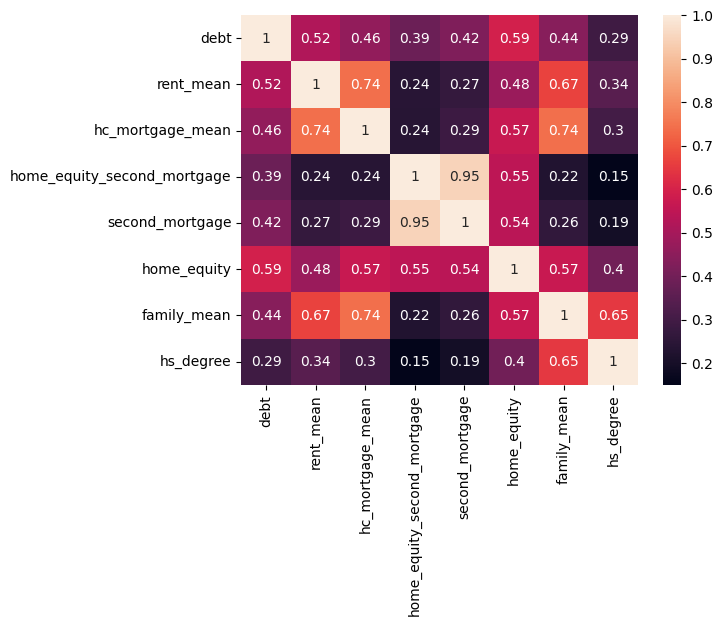

In [4]:
import seaborn as sb

data = df_sampled[['debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean', 'hs_degree']]
dataplot=sb.heatmap(data.corr(), annot=True)

# Neural Network

In [5]:
# defines X and y datasets
data_no_hs_degree = df_sampled[['debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean']]
X = data_no_hs_degree
y = df_sampled['hs_degree']

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# splits data into X and y training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

# defines network model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='linear'))

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# optimizer
initial_learning_rate = 0.001  # learning rate
optimizer = Adam(learning_rate=initial_learning_rate)

# learning rate scheduler
def lr_scheduler(epoch):
    return initial_learning_rate * 0.95 ** epoch
lr_callback = LearningRateScheduler(lr_scheduler)

# trains model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.fit(StandardScaler().fit_transform(X_train), y_train, batch_size = 1, epochs = 100, callbacks=[lr_callback])

Epoch 1/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.5966 - mae: 0.6400 - learning_rate: 0.0010
Epoch 2/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0482 - mae: 0.1678 - learning_rate: 9.5000e-04
Epoch 3/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0227 - mae: 0.1111 - learning_rate: 9.0250e-04
Epoch 4/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - mae: 0.1034 - learning_rate: 8.5737e-04
Epoch 5/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0138 - mae: 0.0954 - learning_rate: 8.1451e-04
Epoch 6/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - mae: 0.0723 - learning_rate: 7.7378e-04
Epoch 7/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0083 - mae: 0.0718 - learning_rate: 7.3509e-04
Epoch 8/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - mae: 0.0725 - learning_rate: 6.9834e-04
Epoch 9/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0065 - mae: 0.0644 - learning_rate: 6.6342e-04
Epoch 10/100
2

In [9]:
# performs predictions
y_pred = model.predict(StandardScaler().fit_transform(X_test))

# mean percent error metric
def mean_percent_error(y_test, y_pred):
    y_test = tf.cast(tf.reshape(y_test, [-1]), dtype=tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)
    mpe = tf.abs(tf.reduce_mean((y_test - y_pred) / y_test) * 100)
    return mpe

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.3f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

mpe = mean_percent_error(y_test, y_pred)
print(f"Mean Percent Error: {mpe:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
R-squared: 0.303
Mean Absolute Error: 0.0718
Root Mean Squared Error: 0.0953
Mean Percent Error: 2.14%


# Decision Tree Regression

In [10]:
from sklearn.tree import DecisionTreeRegressor

# find X and y
X = df_sampled[['debt', 'family_mean']]
y = df_sampled['hs_degree']

# separates data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creates the decision tree classifier
regressor = DecisionTreeRegressor(random_state=42, max_depth=5)
regressor.fit(X_train, y_train)

# makes predictions
y_pred = regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.3f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

mpe = mean_percent_error(y_test, y_pred)
print(f"Mean Percent Error: {mpe:.2f}%")

R-squared: 0.157
Mean Absolute Error: 0.0678
Root Mean Squared Error: 0.1010
Mean Percent Error: 4.58%


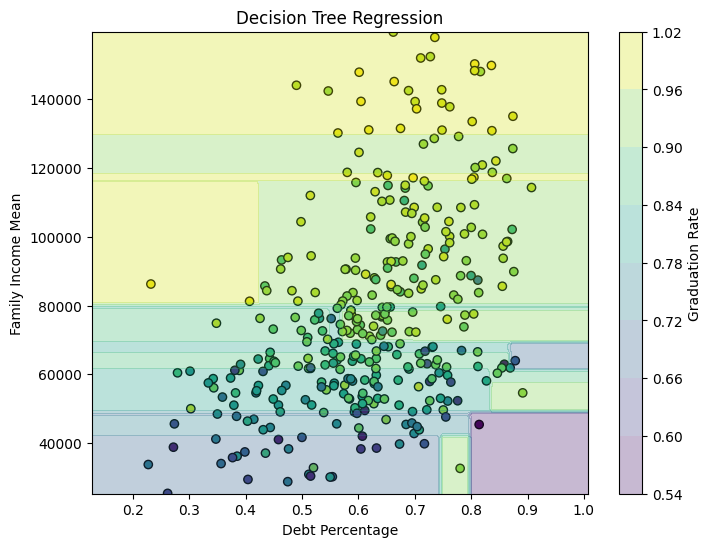

In [11]:
import matplotlib.pyplot as plt

# plots regression tree
plt.figure(figsize=(8, 6))
plt.scatter(X['debt'], X['family_mean'], c=y, cmap='viridis', edgecolors='k')
xx, yy = np.meshgrid(np.linspace(X['debt'].min() - 0.1, X['debt'].max() + 0.1, 100), np.linspace(X['family_mean'].min() - 100, X['family_mean'].max() + 100, 100))
grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
Z = regressor.predict(grid_df).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.xlabel('Debt Percentage')
plt.ylabel('Family Income Mean')
plt.title('Decision Tree Regression')
plt.colorbar(label='Graduation Rate')
plt.show()

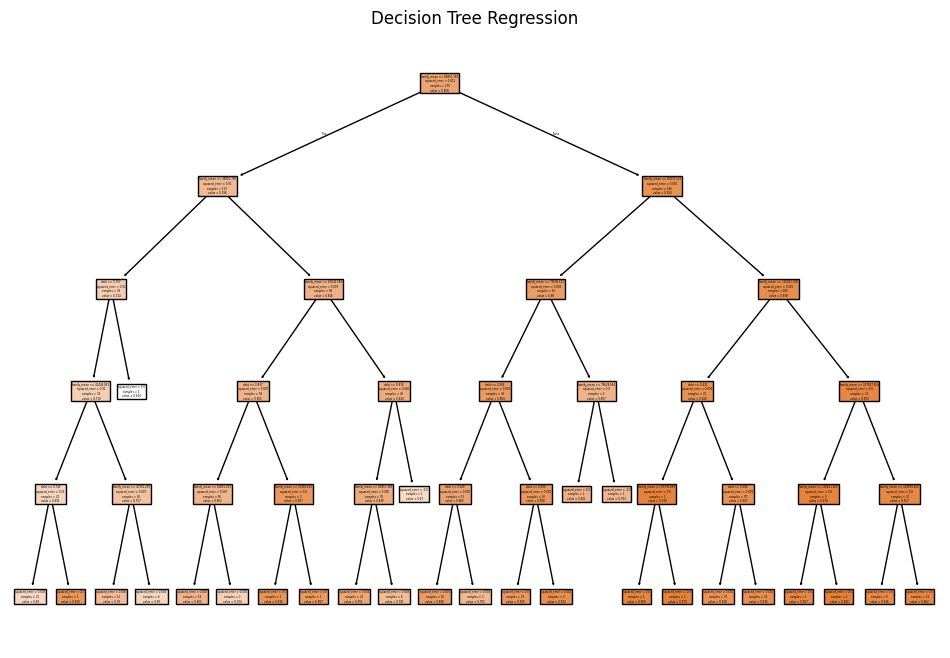

In [12]:
from sklearn.tree import plot_tree

# plots the decision tree
plt.figure(figsize=(12, 8))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.title('Decision Tree Regression')
plt.show()

# Random Forest Classification

In [13]:
from sklearn.ensemble import RandomForestRegressor

# identify the X and y
X = df_sampled[['debt', 'family_mean']]
y = df_sampled['hs_degree']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creates the random forest classifier
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# makes predictions
y_pred = regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.3f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

mpe = mean_percent_error(y_test, y_pred)
print(f"Mean Percent Error: {mpe:.2f}%")

R-squared: 0.200
Mean Absolute Error: 0.0682
Root Mean Squared Error: 0.0983
Mean Percent Error: 4.07%


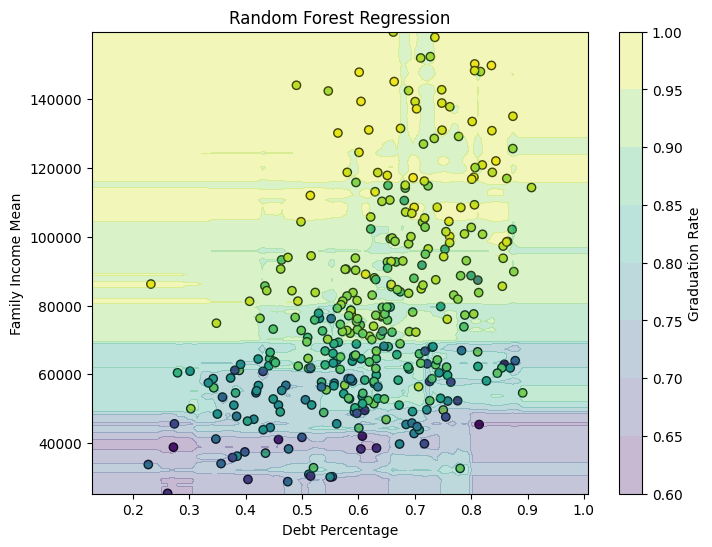

In [14]:
# plots boundaries
plt.figure(figsize=(8, 6))
plt.scatter(X['debt'], X['family_mean'], c=y, cmap='viridis', edgecolors='k')
xx, yy = np.meshgrid(np.linspace(X['debt'].min() - 0.1, X['debt'].max() + 0.1, 100), np.linspace(X['family_mean'].min() - 100, X['family_mean'].max() + 100, 100))
grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
Z = regressor.predict(grid_df).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.xlabel('Debt Percentage')
plt.ylabel('Family Income Mean')
plt.title('Random Forest Regression')
plt.colorbar(label='Graduation Rate')
plt.show()

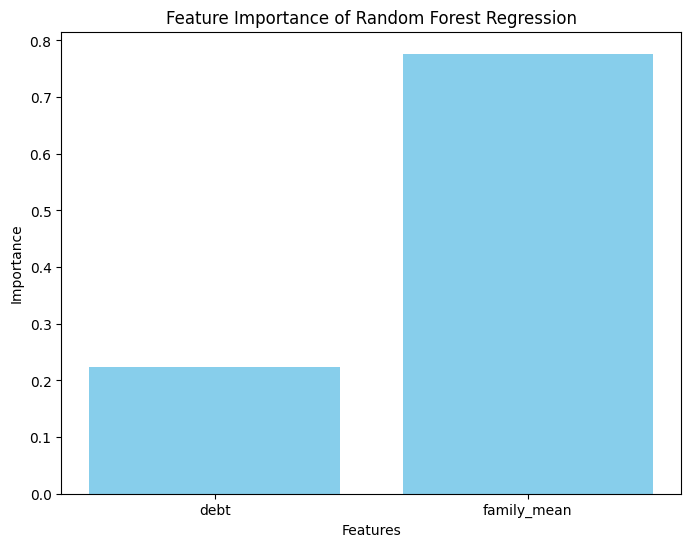

In [15]:
# plots features
plt.figure(figsize=(8, 6))
plt.bar(X.columns, regressor.feature_importances_, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance of Random Forest Regression')
plt.show()

# Interactive US Map

In [16]:
import plotly.express as px

avg_grad_rates = df.groupby('state_ab')['hs_degree'].mean().reset_index()
fig = px.choropleth(avg_grad_rates, locations='state_ab', locationmode='USA-states', color='hs_degree', hover_name='state_ab', color_continuous_scale='blues', title='Average High School Graduation Rates by State')
fig.update_layout(geo_scope='usa')
fig.show()

# Scatterplot of Degree Percentage versus Debt Percentage

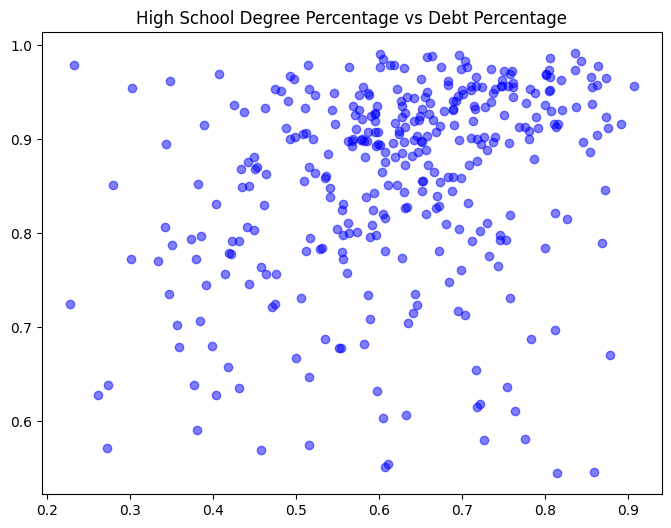

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['debt'], df_sampled['hs_degree'], color='b', alpha=0.5)
plt.title('High School Degree Percentage vs Debt Percentage')
plt.show()

# Line Chart of Graduation Rate versus Debt Percentage

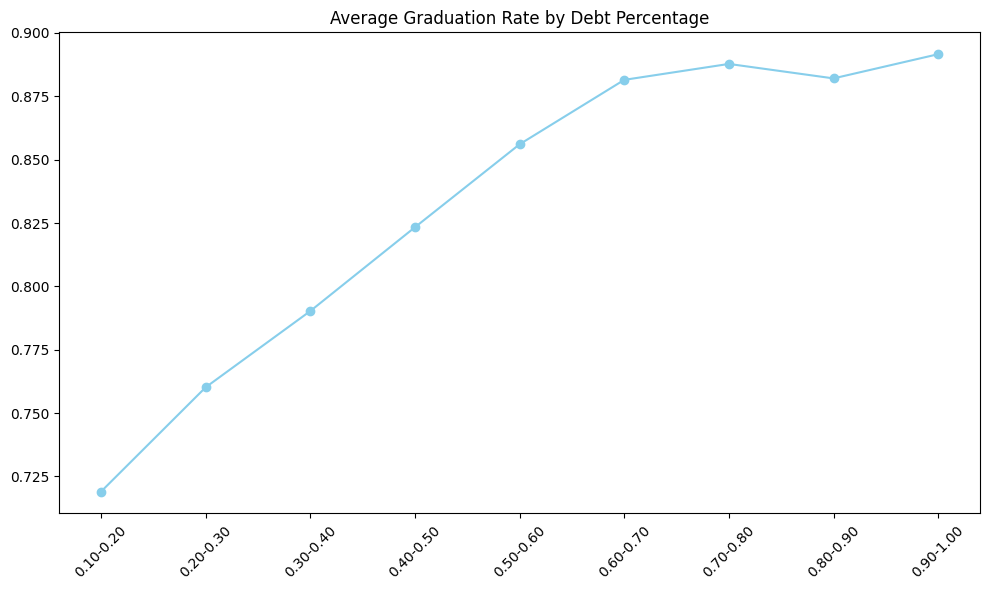

In [18]:
bins = np.linspace(0, 1, 11)
labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
df['debt_binned'] = pd.cut(df['debt'], bins=bins, labels=labels, right=False)
avg_graduation_rate = df.groupby('debt_binned', observed=True)['hs_degree'].mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_graduation_rate.index, avg_graduation_rate.values, marker='o', linestyle='-', color='skyblue')
plt.title('Average Graduation Rate by Debt Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pair Plot of Rent Mean versus Graduation Rate

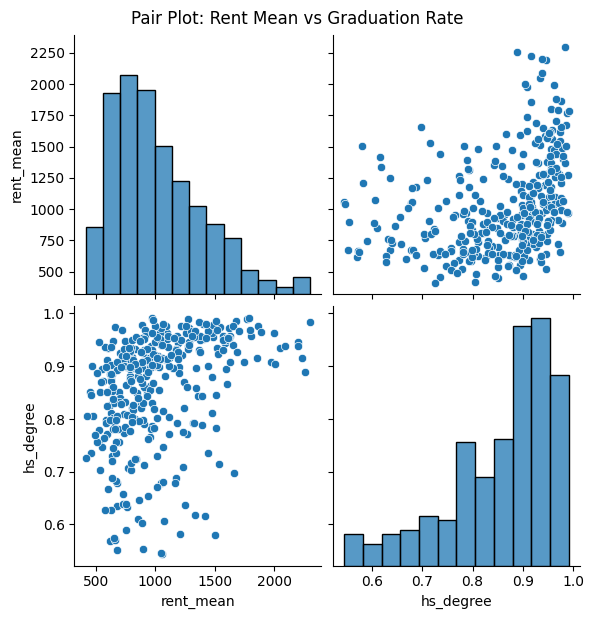

In [19]:
sb.pairplot(df_sampled[['rent_mean', 'hs_degree']], height=3)
plt.suptitle('Pair Plot: Rent Mean vs Graduation Rate', y=1.02)
plt.show()

# Joint Plot of Mortgage Mean versus Graduation Rate

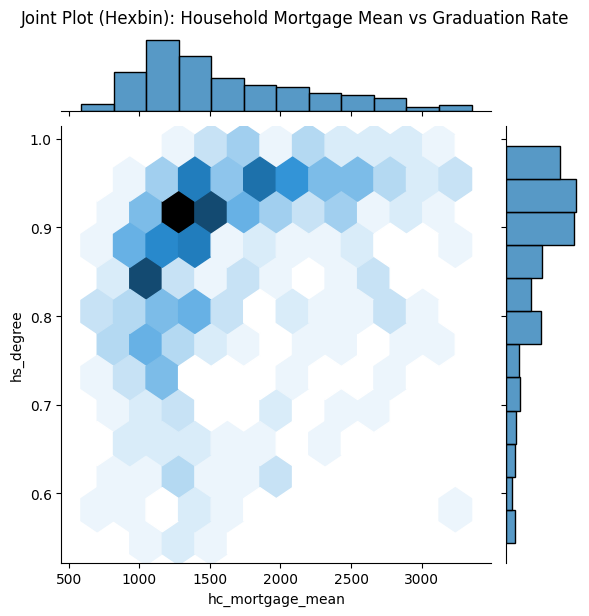

In [20]:
sb.jointplot(x='hc_mortgage_mean', y='hs_degree', data=df_sampled, kind='hex', height=6)
plt.suptitle('Joint Plot (Hexbin): Household Mortgage Mean vs Graduation Rate', y=1.02)
plt.show()

# Scatter Plot of Family Income Mean versus Graduation Rate

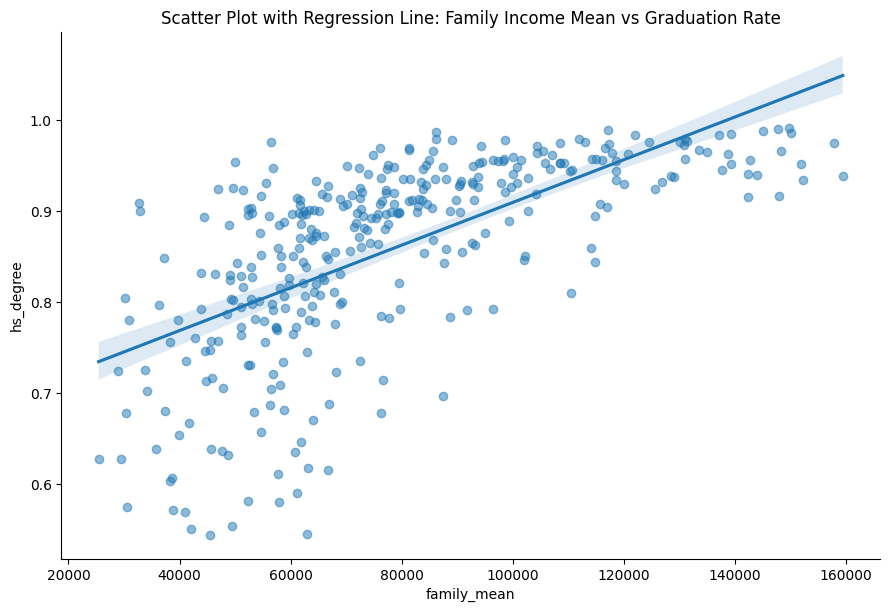

In [21]:
sb.lmplot(x='family_mean', y='hs_degree', data=df_sampled, height=6, aspect=1.5, scatter_kws={'alpha':0.5})
plt.title('Scatter Plot with Regression Line: Family Income Mean vs Graduation Rate')
plt.show()